In [1]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import math
from torchvision import transforms
import os

In [2]:
# 第一步，定义超参数
# 优化算法参数
BETA1 = 0.9
BETA2 = 0.999
# 学习率
LR = 0.005
# 总迭代次数
TOTAL_ITERS = 161

# 原始图像路径
IMAGE_PATH = "data/my_desk.jpg"
# 重构后保存图像的路径
IMAGE_SAVE_PATH = "results/recon_desk.jpg"
IMAGE_SIZE = 256
BATCH_SIZE = 1
DEVICE = "cpu"
# 编码和解码的特征基本数量，决定了模型的容量
NUM_FEATURES = 8
# 保存信息的频率
SAVE_FREQ = 10

In [3]:
# 第二步，准备数据，定义存储结果的容器
class LossWriter():
    def __init__(self, save_dir):
        """
        初始化，loss_writer = LossWriter("xxx/")
        :param save_dir: 损失值保存路径
        """
        self.save_dir = save_dir

    def add(self, loss_name:str, loss, i:int):
        """
        将迭代次数和loss值写入txt
        :param loss_name: 损失函数名
        :param loss: loss.item()
        :param i: 迭代次数
        :return: None
        """
        with open(os.path.join(self.save_dir, loss_name + ".txt"), mode="a") as f:
            term = str(i) + " " + str(loss) + "\n"
            f.write(term)
            f.close()

# 准备输入图像对应的张量数据
image = Image.open(IMAGE_PATH)
trans = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                            transforms.ToTensor()])
image_tensor = trans(image)
image_tensor = image_tensor.unsqueeze(0)

# 定义存储结果的容器
result_images = []
result_iterations = []
loss_writer = LossWriter("results/")

In [4]:
class AE(nn.Module):
    """ Auto Encoder """
    def __init__(self, in_channels, out_channels, nf):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channels, nf, 3, 1, 1),
                                 nn.Conv2d(nf, nf*2, 3, 2, 1),
                                 nn.BatchNorm2d(nf*2),
                                 nn.ReLU(),
                                 nn.Conv2d(nf*2, nf*4, 3, 2, 1),
                                 nn.BatchNorm2d(nf*4),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(nf*4, nf*2, 4, 2, 1),
                                 nn.BatchNorm2d(nf*2),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(nf*2, nf, 4, 2, 1),
                                 nn.BatchNorm2d(nf),
                                 nn.ReLU(),
                                 nn.Conv2d(nf, out_channels, 3, 1, 1),
                                 nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

In [5]:
# 第三步，定义网络结构
ae_net = AE(in_channels=3, out_channels=3, 
            nf=NUM_FEATURES).to(DEVICE)

In [6]:
# 第四步，定义优化器与损失函数
optimizer = torch.optim.Adam(ae_net.parameters(), 
                             lr=LR,
                             betas=(BETA1, BETA2))
mse_loss = nn.MSELoss().to(DEVICE)

In [7]:
# 6: 绘图函数
def plot_list_image(image_list, title_list, save_name):
    """
    plot a list of image with title
    Args:
        image_list: a list of image with numpy type
        title_list: a list of title with str type
        save_name: 图片文件的保存

    Returns:
        True after plot
    """
    plt.figure(figsize=(8, 8))
    w_h = int(math.sqrt(len(image_list)))
    for i in range(w_h*w_h):
        plt.subplot(w_h, w_h, i+1)
        plt.axis("off")
        plt.title(title_list[i])
        plt.imshow(image_list[i])
    plt.savefig(save_name, dpi=500, bbox_inches='tight')
    plt.show()
    return True

iter: 0, loss: 0.052605
iter: 1, loss: 0.039689
iter: 2, loss: 0.026942
iter: 3, loss: 0.020015
iter: 4, loss: 0.015967
iter: 5, loss: 0.013595
iter: 6, loss: 0.012175
iter: 7, loss: 0.011252
iter: 8, loss: 0.010251
iter: 9, loss: 0.009228
iter: 10, loss: 0.008396
iter: 11, loss: 0.007715
iter: 12, loss: 0.007131
iter: 13, loss: 0.006662
iter: 14, loss: 0.006293
iter: 15, loss: 0.005982
iter: 16, loss: 0.005761
iter: 17, loss: 0.005580
iter: 18, loss: 0.005398
iter: 19, loss: 0.005258
iter: 20, loss: 0.005192
iter: 21, loss: 0.005168
iter: 22, loss: 0.005143
iter: 23, loss: 0.005086
iter: 24, loss: 0.004998
iter: 25, loss: 0.004891
iter: 26, loss: 0.004768
iter: 27, loss: 0.004633
iter: 28, loss: 0.004506
iter: 29, loss: 0.004407
iter: 30, loss: 0.004336
iter: 31, loss: 0.004282
iter: 32, loss: 0.004236
iter: 33, loss: 0.004187
iter: 34, loss: 0.004124
iter: 35, loss: 0.004044
iter: 36, loss: 0.003959
iter: 37, loss: 0.003884
iter: 38, loss: 0.003824
iter: 39, loss: 0.003777
iter: 40, 

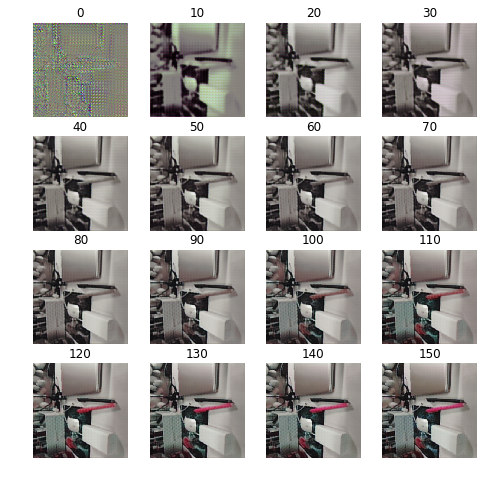

In [8]:
if __name__ == "__main__":
    for iteration in range(TOTAL_ITERS):
        # 步骤(1)：前向传播
        recon_image = ae_net(image_tensor)
        # 步骤(2)：计算损失
        loss = mse_loss(recon_image, image_tensor)
        # 步骤(3)：清空梯度信息
        optimizer.zero_grad()
        # 步骤(4)：进行反向传播，计算梯度
        loss.backward()
        # 步骤(5)：使用优化器更新网络参数
        optimizer.step()
        
        # 输出训练损失函数值，并做记录
        loss_writer.add("mse loss", loss.item(), iteration)
        print("iter: {}, loss: {:.6f}".format(iteration, loss.item()))
        
        # 记录网络的输出图像
        if iteration % SAVE_FREQ == 0:
            result_images.append(recon_image.detach().cpu().numpy().squeeze().transpose(2, 1, 0))
            result_iterations.append(str(iteration))
    # 将训练过程中间生成的图像做拼接，并保存
    plot_list_image(result_images, result_iterations, IMAGE_SAVE_PATH)

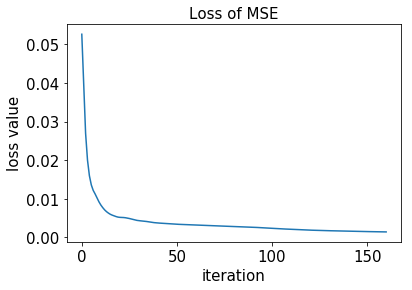

In [9]:
import matplotlib.pyplot as plt


def plot_loss(txt_name, x_label, y_label, title, legend, font_size, fig_size, save_name):
    """
    损失函数绘图代码
    """
    # 分别用于存储迭代次数和对应的损失值
    all_i = []
    all_val = []
    with open(txt_name, "r") as f:
        # 读取txt文件中的所有行
        all_lines = f.readlines()
        # 遍历每一行
        for line in all_lines:
            # 每行的第一个元素和第二个元素以空格分隔
            sp= line.split(" ")
            i = int(sp[0])
            val = float(sp[1])
            all_i.append(i)
            all_val.append(val)
    # 绘图以及参数指定
    plt.figure(figsize=(6, 4))
    plt.plot(all_i, all_val)
    # 设定横纵坐标轴名称
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    # 设置图例
    if legend:
        plt.legend(legend, fontsize=font_size)
    # 设置标题
    plt.title(title, fontsize=font_size)
    plt.tick_params(labelsize=font_size)
    plt.savefig(save_name, dpi=200, bbox_inches = "tight")
    plt.show()
plot_loss(txt_name="results/mse loss.txt", x_label="iteration", 
              y_label="loss value", title="Loss of MSE", 
              legend=None, font_size=15, fig_size=(10, 8),
              save_name="results/mse_loss.png")